# Load libraries and dataset

---



In [0]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# load data
bike_rental = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0103/day.csv")

# Exploratory data anamysis

---



In [0]:
# view few records
bike_rental.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
152,153,2011-06-02,2,0,6,0,4,1,1,0.715000,0.643942,0.305000,0.292287,736,4232,4968
576,577,2012-07-30,3,1,7,0,1,1,1,0.730833,0.684987,0.668750,0.153617,1040,6065,7105
89,90,2011-03-31,2,0,3,0,4,1,3,0.268333,0.257575,0.918333,0.217646,179,1506,1685
316,317,2011-11-13,4,0,11,0,0,0,1,0.440833,0.430550,0.458333,0.281721,1004,2713,3717
641,642,2012-10-03,4,1,10,0,3,1,2,0.657500,0.599133,0.793750,0.066546,728,6844,7572


In [0]:
# view shape of data
bike_rental.shape

(731, 16)

In [0]:
# view data information
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [0]:
# check sum of casual + registered = cnt
bike_rental.iloc[1:5, 13:16]

,casual,registered,cnt
1,131,670,801
2,120,1229,1349
3,108,1454,1562
4,82,1518,1600


In [0]:
# remove unnecessary variables
bike_rental.drop(labels=['instant','dteday','casual','registered'], axis = 1, inplace=True)

In [0]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
cnt           731 non-null int64
dtypes: float64(4), int64(8)
memory usage: 68.7 KB


In [0]:
bike_rental.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


# **Univariant analysis**

---



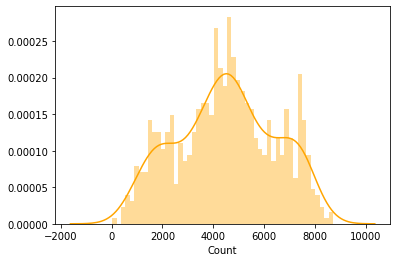

In [0]:
# distribution plot of count
sns.distplot(bike_rental['cnt'],bins=50, color='orange',axlabel='Count')

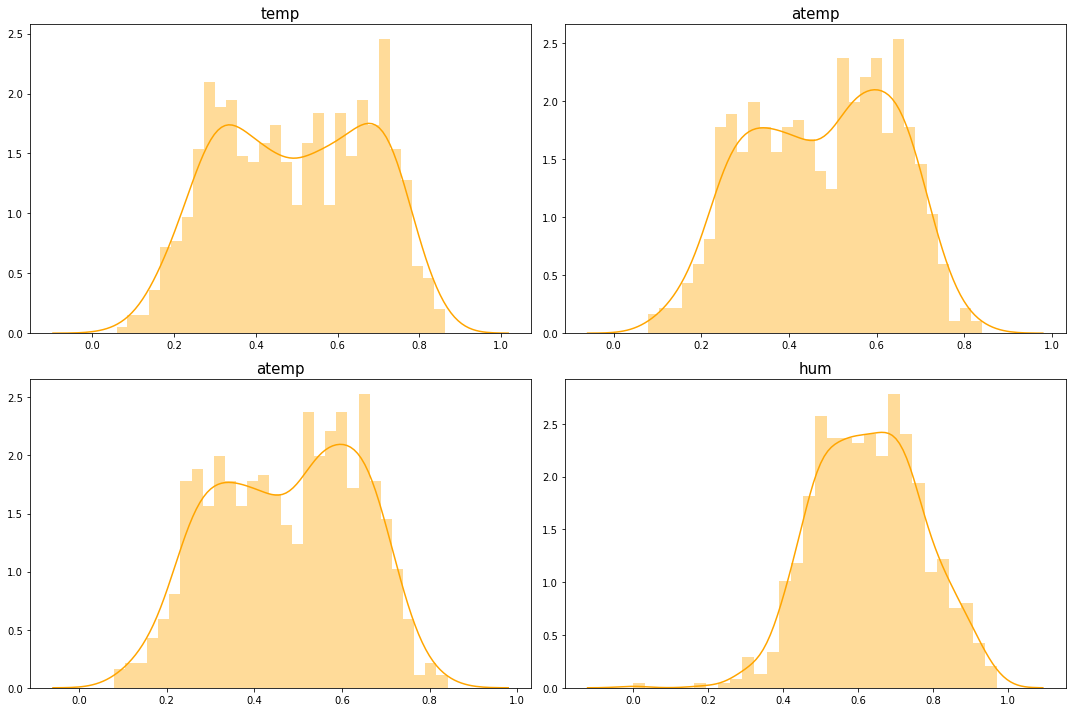

In [0]:
# distribution plot of temp,atemp,hum,windspeed
column_names = ['temp','atemp','hum','windspeed']
fig, axes = plt.subplots(2,2,figsize = (10,5))
count = 0
for row in range(2):
    for col in range(2):
        c_name = column_names[count+col]
        sns.distplot(bike_rental[c_name].values, ax = axes[row][col],bins = 30,color='orange')
        axes[row][col].set_title(c_name,fontsize=15)
        fig=plt.gcf()
        fig.set_size_inches(15,10)
        plt.tight_layout()
    count = count+col    

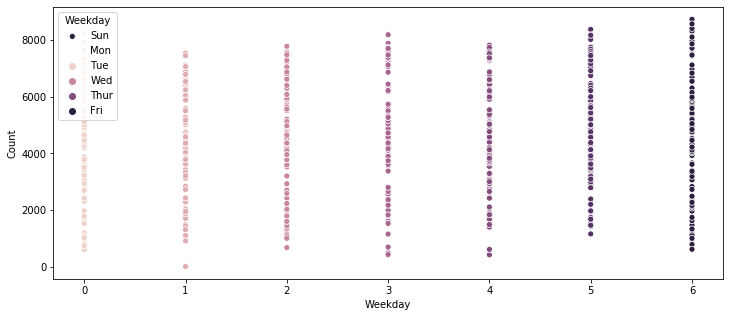

In [0]:
plt.figure(figsize=(12,5))
g = sns.scatterplot(x='weekday',y='cnt', data=bike_rental,size=fig.set_size_inches(12,5),hue='weekday')
plt.xlabel('Weekday')
plt.ylabel('Count')

# label names
new_labels = ['Sun', 'Mon','Tue','Wed','Thur','Fri','Sat']
plt.legend(title='Weekday', labels=new_labels)
plt.show(g)

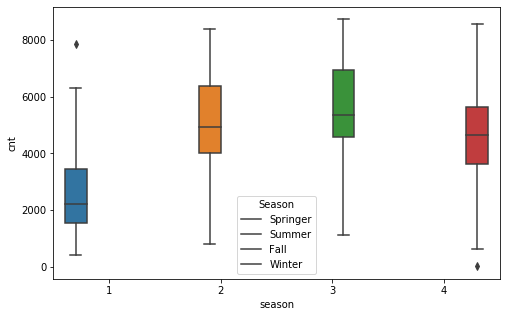

In [0]:
plt.figure(figsize=(8,5))
g = sns.boxplot(x='season',y='cnt',data=bike_rental,hue='season')

# label names
new_labels = ['Springer', 'Summer','Fall','Winter']
plt.legend(title='Season', labels=new_labels)
plt.show(g)

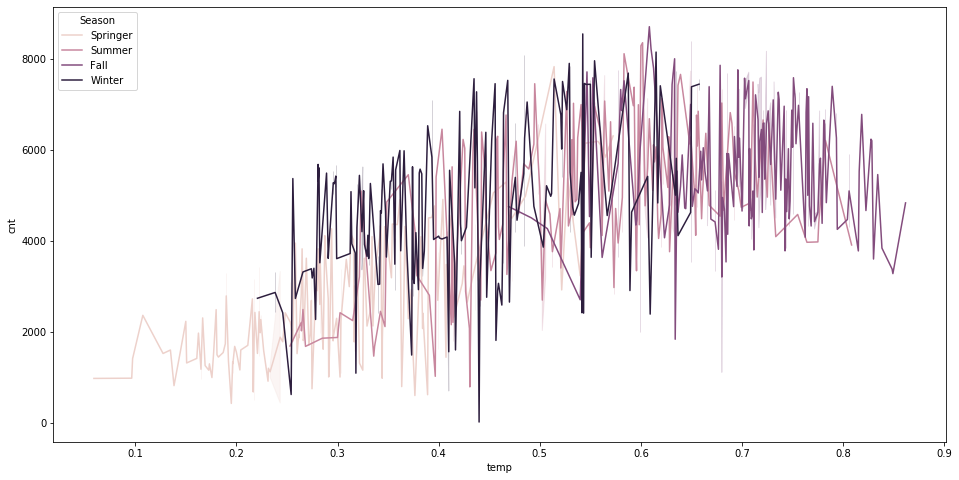

In [0]:
plt.figure(figsize=(16,8))
g = sns.lineplot(x='temp',y='cnt', data=bike_rental,hue='season')

# label names
new_labels = ['Springer', 'Summer','Fall','Winter']
plt.legend(title='Season', loc='upper left', labels=new_labels)
plt.show(g)

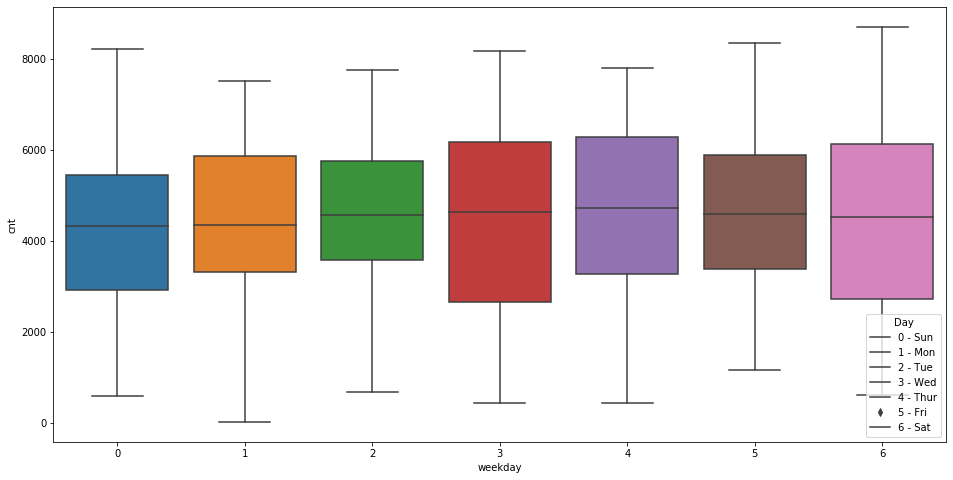

In [0]:
# bike rental count by day of week
plt.figure(figsize=(16,8))
g = sns.boxplot(x='weekday',y='cnt', data=bike_rental)

# label names
new_labels = ['0 - Sun', '1 - Mon','2 - Tue','3 - Wed','4 - Thur','5 - Fri','6 - Sat']
plt.legend(title='Day', loc='lower right', labels=new_labels)
plt.show(g)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


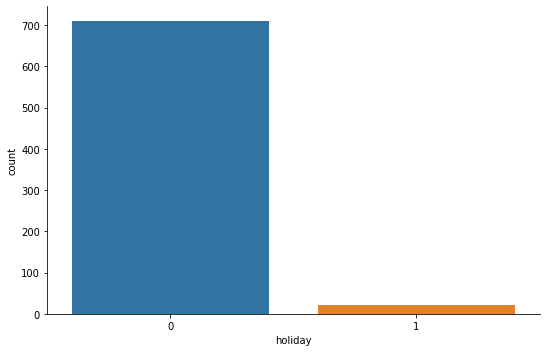

In [0]:
sns.catplot(x='holiday', data = bike_rental, kind='count',aspect=1.5, size=5)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


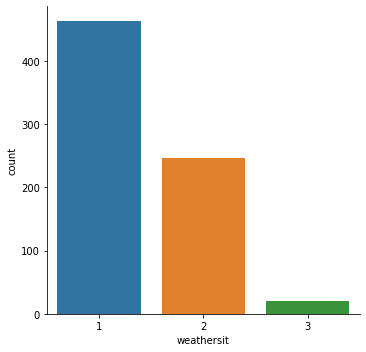

In [0]:
sns.catplot(x='weathersit', data = bike_rental, kind='count',size=5,aspect=1)

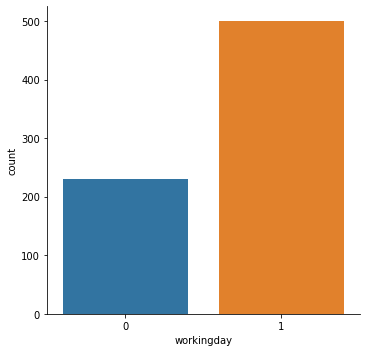

In [0]:
sns.catplot(x='workingday', data = bike_rental ,kind='count')



---


# **Bivariant analysis**

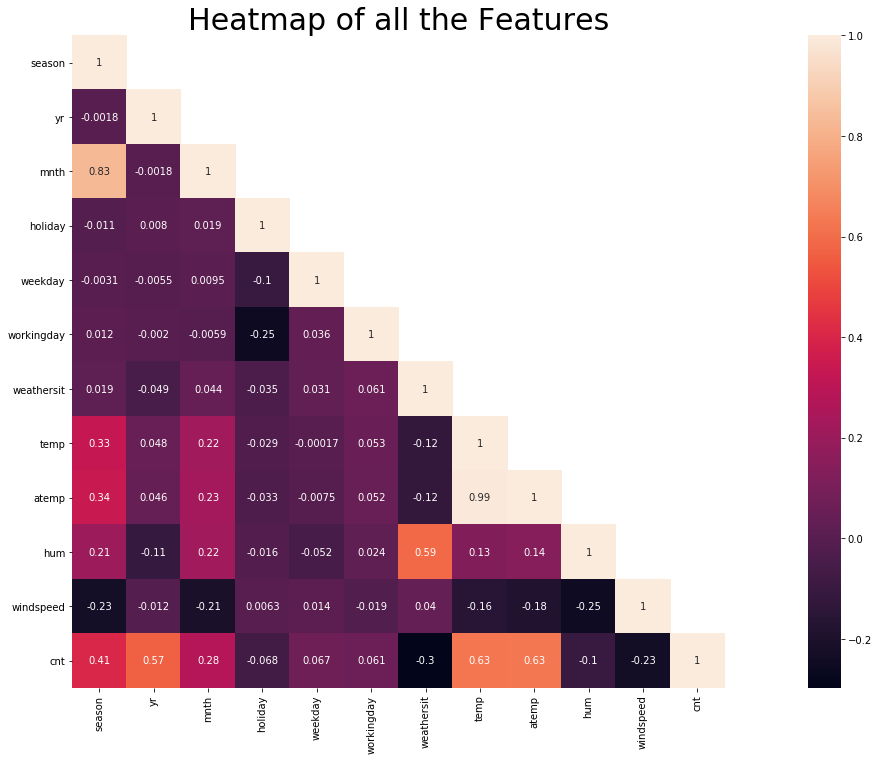

In [0]:
# plot correlation plot

cor_mat= bike_rental[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

In [0]:
# Training set high correlations
df_train_corr = bike_rental.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)

df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

In [0]:
# drop atemp and season
bike_rental.drop(columns=['atemp','season'], inplace=True)

In [0]:
bike_rental.shape

(731, 10)

# **Missing Value analysis**

---




In [0]:
# check missing values
bike_rental.isna().sum().sort_values(ascending=False)

cnt           0
windspeed     0
hum           0
temp          0
weathersit    0
workingday    0
weekday       0
holiday       0
mnth          0
yr            0
dtype: int64



---
# **Outlier Analysis**

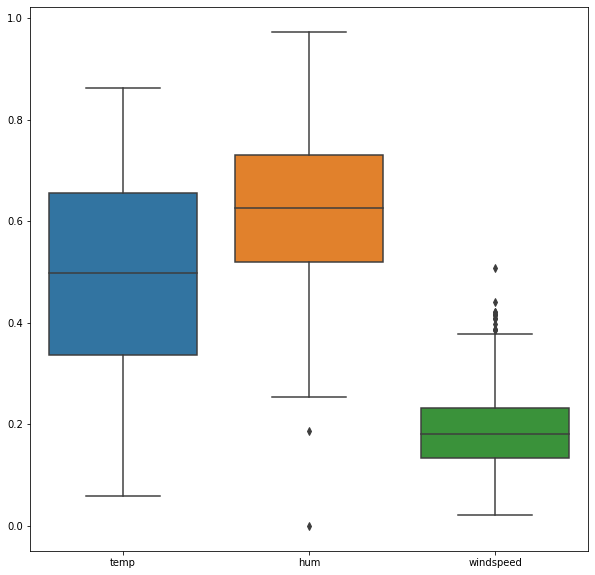

In [0]:
# Outlier analysis
sns.boxplot(data=bike_rental[['temp', 'hum', 'windspeed']])
fig=plt.gcf()
fig.set_size_inches(10,10)

In [0]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 10 columns):
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
cnt           731 non-null int64
dtypes: float64(3), int64(7)
memory usage: 57.2 KB
